# Задача 7. Нейронные сети

1. Найти данные в виде изображений для задачи классификации
2. Реализовать классы, необходимые для построения сети со следующими слоями
    FullyConnectedLayer
    ReluLayer
    FullyConnectedLayer
3. Использовать CrossEntropyLoss и L2-регуляризацию.
4. Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
5. (+2 балла) Добавить Batch normalization.
6. (+2 балла) В качестве оптимизатор использовать один из: Momentum, RMSprop.
7. (+1 балл) Также реализовать оптимизатор Adam.

## Датасет

Для решения задачи классификации с помощью нейронной сети возьмем предложенный в задании датасет [Street View House Numbers (SVHN)](https://www.kaggle.com/datasets/stanfordu/street-view-house-numbers)

In [1]:
!pip install torch
!pip install torchvision

In [67]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.nn import functional
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cpu')

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] → [0.0, 1.0]
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # → [-1, 1]
])

In [ ]:
train_dataset = SVHN(
    root="/Users/kseniia/Desktop/dataset", 
    split='train', 
    download=True, 
    transform=transform)

test_dataset = SVHN(
    root="/Users/kseniia/Desktop/dataset", 
    split='test', 
    download=True, 
    transform=transform)

In [70]:
len(train_dataset), len(test_dataset)

(73257, 26032)

In [71]:
val_size = int(0.3 * len(train_dataset))
train_size = len(train_dataset) - val_size

val_size, train_size

(21977, 51280)

In [72]:
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [73]:
def imshow(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5
    np_img = img_tensor.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))  # (C, H, W) → (H, W, C)
    np_img = np.clip(np_img, 0, 1)
    plt.imshow(np_img)
    plt.axis('off')

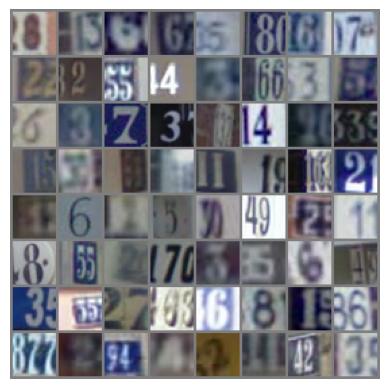

In [75]:
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)  # (B, C, H, W)
imshow(grid)
plt.show()

## Построение сети

In [85]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * torch.sqrt(torch.tensor(2.0 / in_features)))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        self.x = x
        return x @ self.weight + self.bias 


class ReluLayer(nn.Module):
    def forward(self, x):
        self.x = x
        return functional.relu(x)

In [86]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=128, batch_normalization=False):
        super().__init__()
        self.batch_normalization = batch_normalization

        self.fc1 = FullyConnectedLayer(3*32*32, hidden_size)
        self.relu1 = ReluLayer() 
        self.fc2 = FullyConnectedLayer(hidden_size, 10)
        self.batch_norm = nn.BatchNorm1d(hidden_size) if batch_normalization else None

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        if self.batch_normalization:
            x = self.batch_norm(x)
        return x

In [87]:
class AdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
            
            grad = param.grad.data
            if self.weight_decay != 0:
                grad = grad + self.weight_decay * param.data
            
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * grad
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (grad ** 2)
            
            m_hat = self.m[i] / (1 - beta1 ** self.t)
            v_hat = self.v[i] / (1 - beta2 ** self.t)
            
            param.data = param.data - self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()


def get_optimizer(name, params, lr):
    if name == 'adam':
        return AdamOptimizer(params, lr=lr)
    elif name == 'momentum':
        return optim.SGD(params, lr=lr, momentum=0.9)
    else:
        raise ValueError("Unknown optimizer: {}".format(name))

In [88]:
def check_gradient(model, inputs, targets, criterion, delta=1e-3):
    model.zero_grad()
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backward()

    param_list = [param for param in model.parameters() if param.requires_grad]
    total_params = sum(p.numel() for p in param_list)
    num_checks = 15
    if num_checks > total_params:
        num_checks = total_params

    selected_indices = torch.randperm(total_params)[:num_checks]

    for param in param_list:
        print(f"Validating gradient for parameter: {param.shape}")
        param_data_flat = param.data.view(-1)
        param_grad_flat = param.grad.view(-1)

        for idx in selected_indices:
            if idx >= param_data_flat.size(0):
                break

            original_value = param_data_flat[idx].item()
            param_data_flat[idx] = original_value + delta
            loss_plus = criterion(model(inputs), targets).item()
            param_data_flat[idx] = original_value - delta
            loss_minus = criterion(model(inputs), targets).item()
            param_data_flat[idx] = original_value

            estimated_grad = (loss_plus - loss_minus) / (2 * delta)
            actual_grad = param_grad_flat[idx].item()

            if abs(estimated_grad - actual_grad) > delta:
                print(f'Gradient check failed for parameter at index {idx}')
                return False

    print('All gradients are correct!')
    return True

In [89]:
def train(model, trainloader, valloader, criterion, optimizer, epochs=10):
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        

        train_loss.append(running_loss/len(trainloader))
        
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        
        val_loss.append(val_running_loss/len(valloader))
        
        check_gradient(model, *next(iter(trainloader)), criterion)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")
    
    return train_loss, val_loss

Training NeuralNetwork with learning rate 0.001 and optimizer adam
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 1.3989584932006207, Val Loss: 1.1018678909817408
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 0.9565987345806678, Val Loss: 0.9897813421002654
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 3/10, Train Loss: 0.828639068619866, 

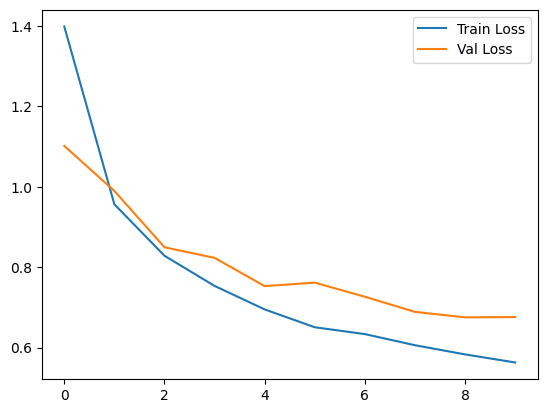

Training NeuralNetwork with learning rate 0.001 and optimizer momentum
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 0.4306328610663402, Val Loss: 0.579875880375851
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 0.4071744303044833, Val Loss: 0.5812468060054058
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 3/10, Train Loss: 0.39834700201514

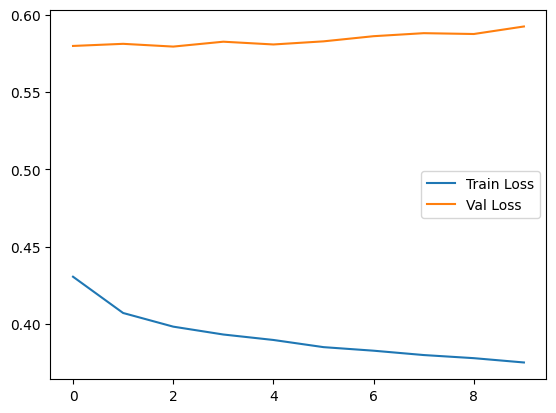

Training NeuralNetwork with learning rate 0.01 and optimizer adam
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 1.789833589199178, Val Loss: 1.2168119984657266
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 1.5420504726673896, Val Loss: 1.7322461223879526
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 3/10, Train Loss: 1.5475689945672813, V

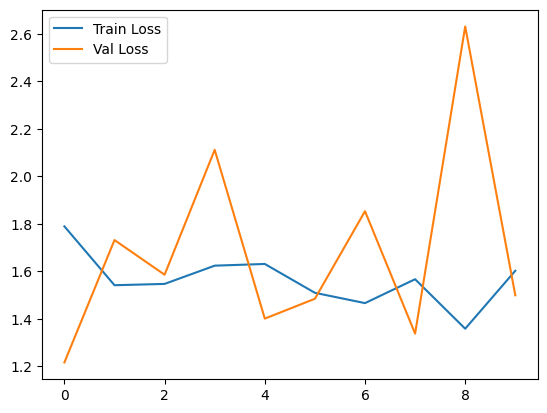

Training NeuralNetwork with learning rate 0.01 and optimizer momentum
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 1/10, Train Loss: 1.550268067943485, Val Loss: 1.7901779297132825
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 2/10, Train Loss: 1.3628104749760426, Val Loss: 1.7171186813434889
Validating gradient for parameter: torch.Size([3072, 128])
Validating gradient for parameter: torch.Size([128])
Validating gradient for parameter: torch.Size([128, 10])
Validating gradient for parameter: torch.Size([10])
All gradients are correct!
Epoch 3/10, Train Loss: 1.297681460059491

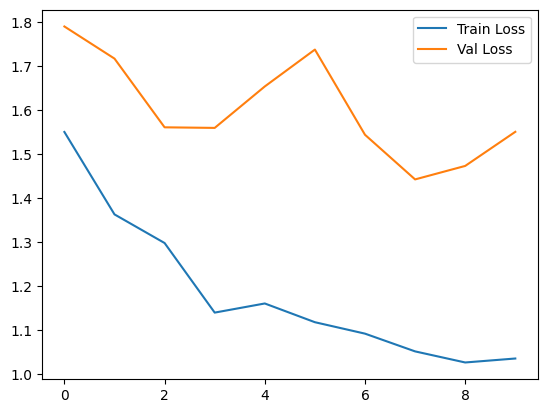

In [90]:
from itertools import product

model = NeuralNetwork(batch_normalization=False)
lrs = [0.001, 0.01]
optimizers = ['adam', 'momentum']
results = []

for lr, optimizer_name in product(lrs, optimizers):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
    
    print(f"Training {model.__class__.__name__} with learning rate {lr} and optimizer {optimizer_name}")
    train_loss, val_loss = train(model, trainloader, valloader, criterion, optimizer)
    result = dict()
    result['train_loss'] = train_loss
    result['val_loss'] = val_loss
    result['model'] = model.__class__.__name__
    result['optimizer'] = optimizer_name
    result['lr'] = lr
    
    results.append(result)
    
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.show()